This file replicates Figure 5. We credit Jaroslav Borovička for the baseline code.

## Bond prices and the yield curve

A zero-coupon risk-free bond is an asset that pays one unit of the numeraire (consumption, dollars) at a pre-specified date. We can therefore denote the price of a bond that is just about to mature in the current period $t$ as

$$Q^{[0]}_t = 1.$$

The superindex $[0]$ denotes time to maturity. Then we can apply the recursive valuation formula: if we have the time $t+1$ price of a bond that has $T-1$ remaining period until maturity, denoted $Q^{[T-1]}_{t+1}$, then we can compute the time-$t$ price as

$$Q_t^{[T]} = E_t \left[ \frac{S_{t+1}}{S_t} Q_{t+1}^{[T-1]} \right].$$

Notice the notation $Q_t^{[T]}$, since in period $t$, the bond has $T$ periods until maturity.

The <b>yield</b> (or yield to maturity) on this bond is the average (per period) return investor earns between today and the maturity of the bond. This yield is safe because the terminal payoff at maturity is fixed. From this definition, the yield is

$$y_t^{[T]} = \frac{1}{T} \log \frac{1}{Q_t^{[T]}} = -\frac{1}{T} \log Q_t^{[T]}.$$

The yield on the one-period bond (bond with maturity equal to one period) is the risk-free rate.

## Matrix implementation

Since the state follows an $n$-state Markov chain, stationary functions of the state $x_t$ can be represented as vectors of length $n$. We can therefore encode the price of a bond with maturity $T$ using a state-dependent price vector $\mathbf{q}^{[T]}$ with entries

\begin{equation*}
\mathbf{q}^{[T]}_{i}=Q^{[T]}\left( x_{t}=e_{i}\right) .
\end{equation*}

Using the matrix structure, the recursive valuation equation can be expressed as

\begin{equation*}
\mathbf{q}^{[T]}_{i}=q\left( x_{t}=e_{i}\right) =\sum_{j=1}^{n}%
\left[ \mathbf{P}\right] _{ij}\left[ \Gamma _{S}\right] _{ij} \mathbf{q}^{[T-1]}_{j}.
\end{equation*}

This can be written in compact form as

\begin{equation*}
\mathbf{q}^{[T]}=\left( \mathbf{P}\ast \Gamma _{S}\right)
 \mathbf{q}^{[T-1]}
\end{equation*}

where $\ast$ is the symbol for elementwise multiplication and $\mathbf{1}$ is a vector of ones.

Consequently, the yield for the bond with maturity $T$ is given by

$$\mathbf{y}^{[T]} = -\frac{1}{T}\log \mathbf{q}^{[T]}.$$

Plotting the yield curve in a particular state $x_t = e_i$ corresponds to plotting $\mathbf{y}^{[T]}_i$ as a function of $T$ for the selected range of horizons.

## Numerical implementation

The numerical implementation extends the function <b>solve_Mehra_Prescott</b>.

Import relevant packages.

In [1]:
# import packages
import numpy as np

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


Function that solves for asset pricing moments in the Mehra-Prescott economy.

In [2]:
def solve_Mehra_Prescott(model):
    
    S = model["SDF"]
    P = model["P"]
    GAMMAG = model["GAMMAG"]
    
    N = P.shape[0]
    I = np.identity(N)
    one = np.ones([N,1])
    
    # first compute the unconditional stationary distribution PII (assuming it is unique)
    # unconditional stationary distribution is the eigenvector of P' associated
    # with eigenvalue equal to 1 (the largest eigenvalue)
    eigval,eigvec = np.linalg.eig(P.transpose())
    idx = np.abs(eigval).argsort()
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    PII = eigvec[:,-1:] /sum( eigvec[:,-1])

    # conditional gross risk-free rate (Nx1 vector)
    # Rf = 1 / (np.multiply(P,S)*one)
    Rf = 1 / ((P * S) @ one)
    # unconditional gross risk-free rate, stored as a scalar
    ERf = (Rf.transpose() @ PII).item()
    
    # recursive formula for the price-dividend ratio: q =  P*S*GAMMAG @ (q + 1)
    # where * is elementwise multiplication, @ is matrix multiplication, 1 is an Nx1 vector of ones
    # solution given by
    # q = inv(I - P*S*GAMMAG) * (P*S*GAMMAG)*1

    # solution for the infinite-horizon asset only valid
    # if P*S*G has eigenvalues inside the unit circle
    M = P*S*GAMMAG
    eigval,eigvec = np.linalg.eig(M)
    maxeig = max(eigval)

    if (maxeig < 1):
        # asset price (Nx1 vector)
        q = np.linalg.inv(I - M) @ (M @ one)
        # returns (NxN matrix of returns R(i,j)
        R = ((1/q) @ (q.transpose()+1)) * GAMMAG
        # conditional expected returns (Nx1 vector)
        EtR = (R * P) @ one
        # unconditional expected return
        ER = (EtR.transpose() @ PII).item()
        # excess returns, realized and expected
        Re = R - np.tile(Rf,[1,N])
        EtRe = EtR - Rf
        ERe = ER - ERf
    else:
        q = (np.empty([N,1]))*np.nan
        R = (np.empty([N,N]))*np.nan
        EtR = (np.empty([N,1]))*np.nan
        ER = np.nan
        Re = (np.empty([N,N]))*np.nan
        EtRe = (np.empty([N,1]))*np.nan
        ERe = np.nan
        
    # compute the yield curve
    capT = 100
    y = np.zeros([N,capT])
    q = np.ones([N,1])
    for T in range(capT):
        q = (P*S) @ q
        y[:,T:T+1] = -1/(T+1)*np.log(q)

    sol = {"PII": PII, "Rf": Rf, "ERf": ERf, "q": q, "R": R, "EtR": EtR, "ER": ER, "Re": Re, "EtRe": EtRe, "ERe": ERe, "y": y}
    return sol

Solve a list of economies.

In [3]:
model = {"PHI": 0.43, "MU": 0.018, "DELTA": 0.036, "d1": 0.024, "d2": 0.024, "p": 0, "psi": 0.85}

model["P"] = np.array([[model["PHI"], 1 - model["PHI"] - model["d1"], model["d1"]], 
                       [1 - model["PHI"] - model["d2"], model["PHI"], model["d2"]],
                       [0.5 - 0.5 * model["p"], 0.5 - 0.5 * model["p"], model["p"]]])

model["GAMMAC"] = np.array([[1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])], 
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])],
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])]])


model["GAMMAG"] = model["GAMMAC"].copy()

# define a list of economies via combinations of parameters [BETA, GAMMA]
model_vec = [[0.99, 2], [0.96, 2], [0.99, 4]]
yield_curves = [0] * 3

for i,m in enumerate(model_vec):
    model["BETA"] = m[0]
    model["GAMMA"] = m[1]
    model["SDF"] = model["BETA"] * np.power(model["GAMMAC"],-model["GAMMA"])
    sol = solve_Mehra_Prescott(model)
    yield_curves[i] = sol["y"]

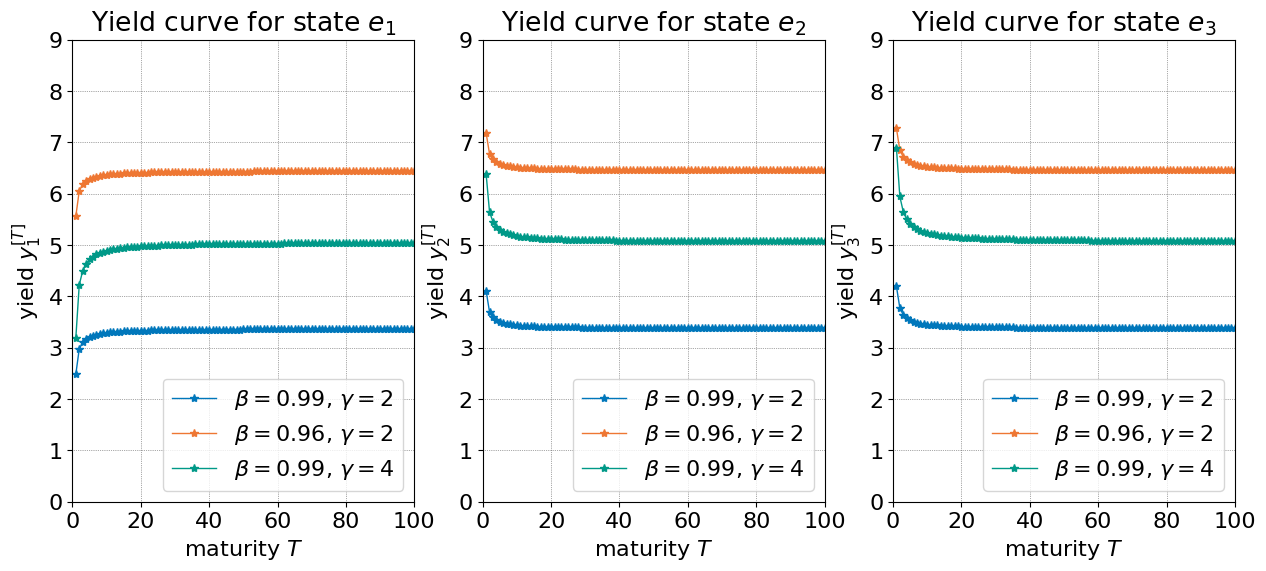

In [4]:
# display yield curve results
capT = yield_curves[0].shape[1]

param = {'figsize' : [15,6], 'fontsize': 16, 'subplots': [1,3],
         'title': '',
         'xlim': [0,capT], 'ylim': [0,9],
         'xlabel': 'maturity $T$', 'ylabel': 'yield $y^{[T]}_1$',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

fig,ax = ec.GenerateTSPlot(param)

ax[0,0].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[0][0,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='$\\beta = ' + str(model_vec[0][0]) + '$, $\\gamma = ' + str(model_vec[0][1]) + ' $');
ax[0,0].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[1][0,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantOrange'],linestyle='solid',label='$\\beta = ' + str(model_vec[1][0]) + '$, $\\gamma = ' + str(model_vec[1][1]) + ' $');
ax[0,0].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[2][0,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantTeal'],linestyle='solid',label='$\\beta = ' + str(model_vec[2][0]) + '$, $\\gamma = ' + str(model_vec[2][1]) + ' $');

ax[0,0].set_title('Yield curve for state $e_1$')
x = ax[0,0].legend(loc="lower right")

ax[0,1].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[0][1,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='$\\beta = ' + str(model_vec[0][0]) + '$, $\\gamma = ' + str(model_vec[0][1]) + ' $');
ax[0,1].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[1][1,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantOrange'],linestyle='solid',label='$\\beta = ' + str(model_vec[1][0]) + '$, $\\gamma = ' + str(model_vec[1][1]) + ' $');
ax[0,1].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[2][1,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantTeal'],linestyle='solid',label='$\\beta = ' + str(model_vec[2][0]) + '$, $\\gamma = ' + str(model_vec[2][1]) + ' $');

ax[0,1].set_title('Yield curve for state $e_2$')
ax[0,1].set_ylabel('yield $y^{[T]}_2$')
x = ax[0,1].legend(loc="lower right")

ax[0,2].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[0][2,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='$\\beta = ' + str(model_vec[0][0]) + '$, $\\gamma = ' + str(model_vec[0][1]) + ' $');
ax[0,2].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[1][2,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantOrange'],linestyle='solid',label='$\\beta = ' + str(model_vec[1][0]) + '$, $\\gamma = ' + str(model_vec[1][1]) + ' $');
ax[0,2].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[2][2,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantTeal'],linestyle='solid',label='$\\beta = ' + str(model_vec[2][0]) + '$, $\\gamma = ' + str(model_vec[2][1]) + ' $');

ax[0,2].set_title('Yield curve for state $e_3$')
ax[0,2].set_ylabel('yield $y^{[T]}_3$')
x = ax[0,2].legend(loc="lower right")

fig.set_facecolor('#FFFFFF')